In [1]:
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import theano
theano.config.floatX = 'float32'
theano.config.openmp = True
import theano.tensor as T
import lasagne
%load_ext autoreload
%autoreload 2

Couldn't import dot_parser, loading of dot files will not be possible.


In [2]:
_shared = lambda name,val,dtype: theano.shared(val.astype(dtype),name,
                                               strict = True,allow_downcast=True)
floatX = theano.config.floatX

# problem statement

In [3]:
arr_len = 25
n_rules = 15

rule_lengths = np.random.normal(3,2,size=n_rules).astype(int)
rule_lengths[rule_lengths<1] = 1

rule_starts = np.random.randint(0,arr_len-1,size=n_rules)

rules = map(lambda x0,l: np.arange(x0,min(x0+l, arr_len)) , rule_starts, rule_lengths)
rules = np.array(rules)

rule_probas = np.repeat(0.5,n_rules)

In [4]:
from itertools import product

def generate_event():
    rule_triggered = rule_probas > np.random.random(size = n_rules)
    rule_triggered = rule_triggered.astype(bool)
    
    arr = np.zeros(arr_len+1).astype(bool) #last one element is needed for theano switch simplicity
    if np.any(rule_triggered):
        arr[np.concatenate(rules[rule_triggered])] = True
    return arr



[array([23]) array([19, 20, 21, 22]) array([3, 4, 5, 6]) array([5, 6, 7])
 array([4, 5, 6, 7, 8]) array([ 6,  7,  8,  9, 10])
 array([20, 21, 22, 23, 24]) array([8]) array([21, 22, 23, 24])
 array([2, 3, 4, 5]) array([20, 21, 22, 23, 24])
 array([ 5,  6,  7,  8,  9, 10, 11]) array([2, 3]) array([0, 1])
 array([2, 3, 4])]


/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


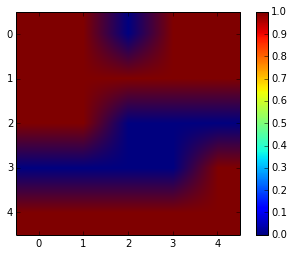

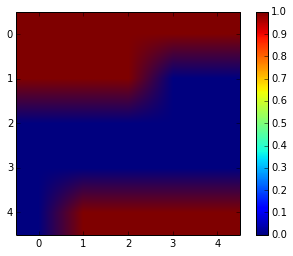

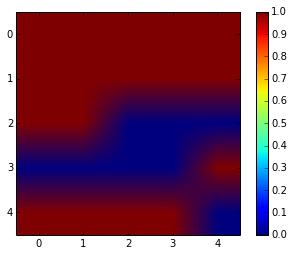

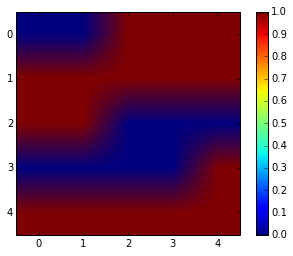

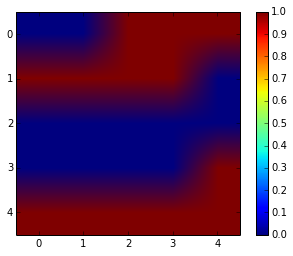

In [5]:
print rules
for i in range(5):
    plt.imshow(generate_event()[:-1].reshape(-1,5))
    plt.colorbar()
    plt.show()

# naive q-learning

In [6]:
class PracticeEnvironment:
    def __init__(self,n_outputs,n_inputs,end_code=None,batch_size=10,seq_len=10): 
        """an environment class that defines what does MDP interact with"""
        self._event = _shared("event_bool_arr",np.zeros([1,n_outputs]),floatX)
        
        self.seq_len = seq_len
        self.batch_size = batch_size
        self.n_outputs = n_outputs
        self.n_inputs = n_inputs
        if end_code is None:
            end_code = self.n_outputs -1
        self.end_code = end_code
        self.generic_input_shape = fake_input_shape = [None,None,1,self.n_inputs]


        
        self._bag_of_randomness = _shared("randomness",
                                          np.random.random([self.seq_len,self.batch_size]),floatX)
        
        self._shape_input = _shared("fake_inp_var_for_shape",
                                    np.zeros([self.batch_size,self.seq_len,1,self.n_outputs]),floatX)


        self.dependencies = [
            self._event,
            self._bag_of_randomness
        ]
        
        
        self.reset_agent = lambda bs,sl: None
    
    def change_shape(self,batch_size,seq_len):
        self.batch_size = batch_size
        self.seq_len = seq_len
        new_inp_shape = np.zeros([self.batch_size,self.seq_len,1,self.n_inputs],dtype=floatX) 
        self._shape_input.set_value( new_inp_shape)
        
        self.prepare_sessions()
        
    def prepare_sessions(self):
        self.reset_agent(self.batch_size,self.seq_len)
        self.load_next_events()
        self.get_some_randomness()
        
        
    def load_next_events(self):
        
        evts = np.concatenate([generate_event()[np.newaxis,:].astype(floatX)
                               for i in range(self.batch_size)],axis=0)
        
        self._event.set_value(evts)
        
        
    def get_some_randomness(self):
        """reloads the shared random variable sequences used instead of real-time RNG to avoid problems with
        T.scan updates."""
        randomness_shape = (self.seq_len,self.batch_size)
        self._bag_of_randomness.set_value(
            np.random.random(randomness_shape).astype(floatX))
    
    def get_action_probas(self,hidden_activation):
        return hidden_activation / hidden_activation.sum(axis=1,keepdims=True)
    
    def decision_by_hidden(self,itr,hidden_activation): #has to be deterministic function
        """take 1D float32 array and return action code.
        Action code must be stackable with hidden_activation
        Do not use random INSIDE. It's okay to pre-generate randomness"""
        
        probas = self.get_action_probas(hidden_activation) #[batch_size,n-actions]
        
        #softmax sampling
        cum_probas = probas.cumsum(axis=1) #[batch_size,n-actions]
        
        batch_of_random = self._bag_of_randomness[itr,:] #batch_size of floatX
        batch_of_random = batch_of_random.reshape([-1,1]) 
        
        #cum_probas are `guaranteed` to sum to zero but there can a problem with float32 inaccuracy,
        #so to avoid choice_id being > number of choices, we cut that last `1` out

        choices = (batch_of_random > cum_probas[:,:-1]).sum(axis=1).astype('int32')
        

        
        return T.extra_ops.to_one_hot(choices,nb_class = self.n_outputs)
        
    def input_by_decision(self,itr,decision): #has to be deterministic function
        """take action code and return the next input observation.
        Do not use random INSIDE. It's okay to pre-generate randomness"""
        
        dec_ids = T.argmax(decision,axis=1)
        
        _regular_response =  self._event[T.arange(dec_ids.shape[0]),dec_ids]

        
        return T.switch( T.eq(dec_ids ,self.end_code), 0, _regular_response
                       ).reshape([-1,self.n_inputs])#last 1 is the input shape
        
    def decision_init_factory(self):
        """returns a value for '-1st' action, that is than aligned to the zero-tick
        hidden state"""
        dec0 = np.zeros( self.n_outputs ,dtype=floatX)
        dec0[0] =1
        return dec0
    def on_new_session(self,function):
        """takes a function of (batch_size, input_size) and
        calls it before each new session start"""
        self.reset_agent = function
        
    def get_feedback(self,response_history,decision_history,strict = True):
        """
        response_history - mdp network responses for each time and batch [floatX(batch,sequence,units)]
        decision_history - mdp decisions that were chosen during training iteration [floatX(batch,sequence,units)]
        Assumes response and decision shapes to be [batch_id,seq_length,unit]
        returns:
        rewards[batch,time], reward in given batch at given time
        is_alive[batch,time], whether the batch's session has ended by the BEGINNING of time'th iteration
        committed_action_id[batch,time], index [int] of the action committed in given batch at given time
        response[batch,time,n_units], nn output at given batch/time
        """


        #reshape inputs
        _predicted_Qvalues = response_history.dimshuffle(1,0,2)
        _commited_actions =  decision_history.dimshuffle(1,0,2)
        _commited_action_ids = T.argmax(_commited_actions,-1)


        #init a variable in which ones indicate inputs that were tried 
        # already within a session (used in T.scan later)
        _attempted_init =T.zeros_like(_commited_actions[0,:,:],dtype=floatX) #[batch,units]


        _batch_shaped = _commited_actions[0,:,0]
        outputs_info = [_attempted_init,
                        T.zeros_like(_batch_shaped,dtype=floatX),
                        T.ones_like(_batch_shaped,dtype='int8')
                       ]
        non_sequences = [self._event]



        sequences = [_commited_action_ids]

        def reward_computation_step(decision_code,

                                    fields_attempted_ext,
                                    last_reward,
                                    session_active,

                                    event_arr_ext,*args):
            """i am used to compute the stepwise reward function via scan
            decision_code - int32 vector (batch_i) - what decision was taken during THIS STEP
            fields_attempted - int8 matrix (batch_i, array field id) - what fields were checked already
            last_reward - float32 vector (batch_i) - reward on previous step
            session_active - int8 vector (batch_i) - whether session is still not finished AFTER PREVIOUS_STEP
            event_arr - an array (int8) of game stage"""



            batch_i = T.arange(decision_code.shape[0],dtype='int32')
            ones_batch = T.ones_like(decision_code,dtype=floatX,)
            zeros_batch = T.zeros_like(decision_code,dtype=floatX,)


            #step

            has_finished_now = T.eq(decision_code,self.end_code)

            session_still_active = session_active*(1-has_finished_now) # array [batch_i] of bool

            is_first_time = T.eq(fields_attempted_ext[batch_i,decision_code],0)

            first_time_reward = (2*event_arr_ext[batch_i,decision_code] -1.).astype(floatX)

            current_reward = T.switch(session_still_active,                                
                                            T.switch(is_first_time,
                                                        first_time_reward,
                                                        -0.5*ones_batch
                                                    ),
                                            0.*zeros_batch
                                    )


            fields_attempted_now_ext = T.set_subtensor(
                fields_attempted_ext[batch_i,decision_code], ones_batch)

            #current_reward
            return fields_attempted_now_ext,current_reward,session_still_active

        attempted_ext,rewards,session_is_alive = theano.scan(
                                                reward_computation_step,
                                                sequences,
                                                outputs_info,
                                                non_sequences,
                                                strict=True)[0]
        attempted_ext = attempted_ext[-1]

        #take account for that rewards indicate whether session lasts for the NEXT step (and we wand current step)
        #shape so far: seq_len, batch_i (will be transposed later in this function)

        session_is_alive = T.vertical_stack(
            T.ones_like(_batch_shaped,dtype='int8').reshape([1,-1]),# padding
            session_is_alive[:-1,:], #actual session status for current step

        )

        _commited_actions = _commited_actions.dimshuffle([1,0,2])
        _predicted_Qvalues = _predicted_Qvalues.dimshuffle([1,0,2])

        return rewards.T,session_is_alive.T,_commited_action_ids.T,_predicted_Qvalues

In [7]:

from retina.MDPlayer import GRULayer
env = PracticeEnvironment(arr_len+1,1)

env.change_shape(10,100) #10 sessions, 50 hits each
#gotta run this each time you start a new batch.

mdp_hidden_size = 50

##auxilary nn that transforms mdp_nn hidden units into predictions
#shape batch_i,mdp_units
_mdp_inner = lasagne.layers.InputLayer(shape=[None,mdp_hidden_size],name="mdp_hidden_to_output_inp") 


_greediness = _shared("greediness",np.float32(3.),floatX)
_mdp_inner = lasagne.layers.DenseLayer(_mdp_inner,name="mdp_hidden_to_output_dense0",
                                       num_units=env.n_outputs,
                                      nonlinearity = lambda x: lasagne.nonlinearities.softmax(_greediness*x))
env.dependencies.append(_greediness)

##mdp layer itself

_nn_inp = lasagne.layers.InputLayer( env.generic_input_shape  ,name="fake_inp_layer",
                                          input_var = env._shape_input)   

_rnn = GRULayer(_nn_inp,mdp_hidden_size,env,
                hidden_to_output_network = _mdp_inner,
                name="mdp_gru")


#a network layer that's used inside mdp _rnn to make decisions

#init trainer
env.prepare_sessions()


In [8]:
_prediction = lasagne.layers.get_output(_rnn)



called get_output


/usr/local/lib/python2.7/dist-packages/theano/scan_module/scan.py:1019: Warning: In the strict mode, all neccessary shared variables must be passed as a part of non_sequences
  'must be passed as a part of non_sequences', Warning)


In [9]:
#theano.config.exception_verbosity='high'
#theano.config.compute_test_value = 'warn'

[(10, 100, 50), (10, 100, 26), (10, 100, 26)]


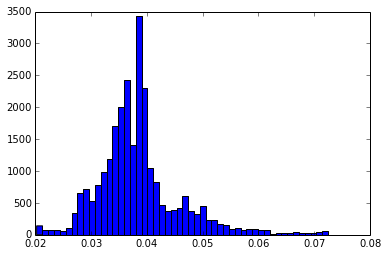

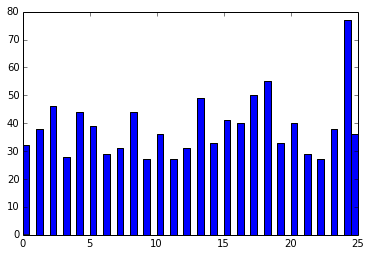

In [10]:
#howto run
env.prepare_sessions()

predict = theano.function([],_prediction,mode=theano.compile.mode.FAST_COMPILE)


pred_history = predict()


hid_history,resp_history,dec_history = pred_history
print [channel.shape for channel in pred_history]

plt.hist(resp_history.ravel(),bins=50)
plt.show()
_= plt.hist(dec_history.argmax(-1).ravel(),bins=50)


# learning

In [11]:
from retina.MDPlayer import get_reference_tuples

In [12]:


_hid_history,_resp_history,_dec_history  = _prediction

_feedback = env.get_feedback(_resp_history,_dec_history)

#gamma - delayed reward coefficient - what fraction of reward is retained if it is obtained one tick later
_gamma = _shared('q_learning_gamma',np.float32(0.99),floatX)

_action_ids,_rewards, _predicted_Qvalues, _reference_Qvalues= get_reference_tuples(*_feedback,
                                                                                   _gamma_or_gammas=_gamma,
                                                                                   end_code=env.end_code)



_loss = lasagne.objectives.squared_error(_predicted_Qvalues[T.arange(_action_ids.shape[0]),_action_ids]
                                         ,_reference_Qvalues)


# training, finally

In [13]:
_weights = lasagne.layers.get_all_params(_rnn)
_weights

[mdp_hidden_to_output_dense0.b,
 mdp_hidden_to_output_dense0.W,
 mdp_gru.W_in_to_updategate,
 mdp_gru.W_hid_to_updategate,
 mdp_gru.b_updategate,
 mdp_gru.W_in_to_resetgate,
 mdp_gru.W_hid_to_resetgate,
 mdp_gru.b_resetgate,
 mdp_gru.W_in_to_hidden_update,
 mdp_gru.W_hid_to_hidden_update,
 mdp_gru.b_hidden_update]

In [14]:
_updates = lasagne.updates.nesterov_momentum(_loss.mean(),_weights,learning_rate=0.01)

In [15]:
train_fun = theano.function([],_rewards.mean(),updates=_updates)

In [16]:
env.change_shape(100,50)
env.prepare_sessions()
ma_reward = train_fun()
alpha = 0.01

epochCounter = 0
rewards = {}

epoch 0, reward -0.142094085589, greed 3.0


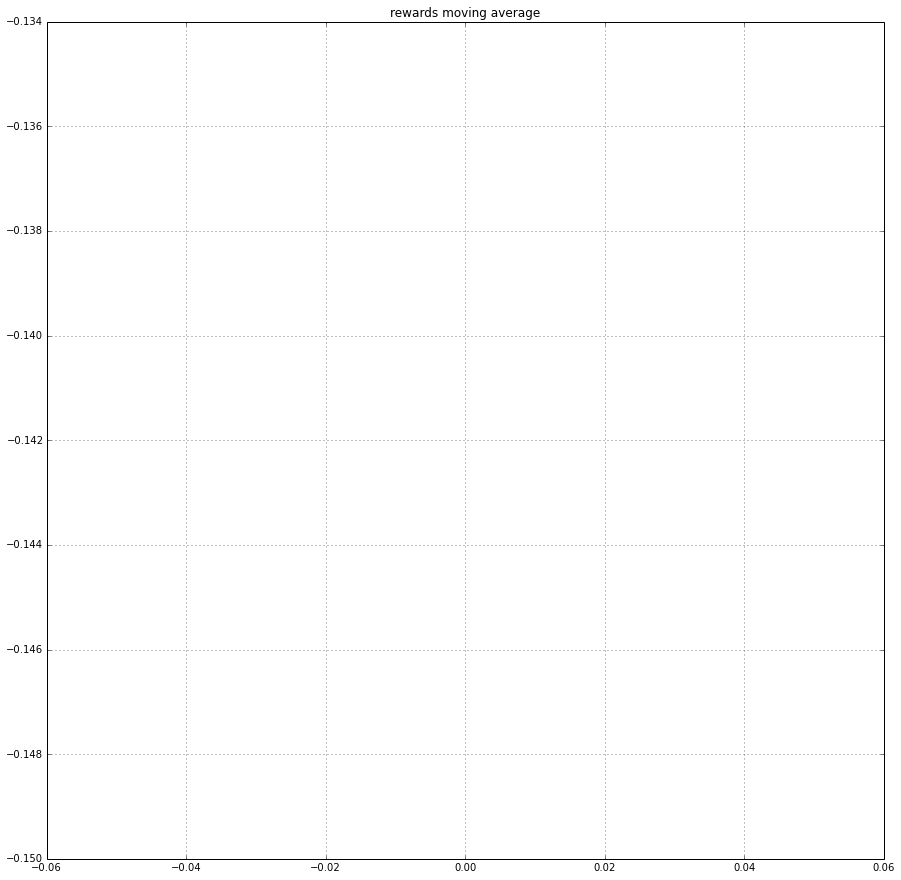

epoch 100, reward -0.121469374518, greed 0.10000000149
epoch 200, reward -0.115014028832, greed 0.119802623987
epoch 300, reward -0.109794962153, greed 0.139220714569
epoch 400, reward -0.106358426385, greed 0.158268913627
epoch 500, reward -0.105172622284, greed 0.176961034536
epoch 600, reward -0.104733258873, greed 0.195310175419
epoch 700, reward -0.103693088565, greed 0.213328689337
epoch 800, reward -0.102375004447, greed 0.231028258801
epoch 900, reward -0.100938919574, greed 0.248420000076
epoch 1000, reward -0.0946277033873, greed 0.265514433384


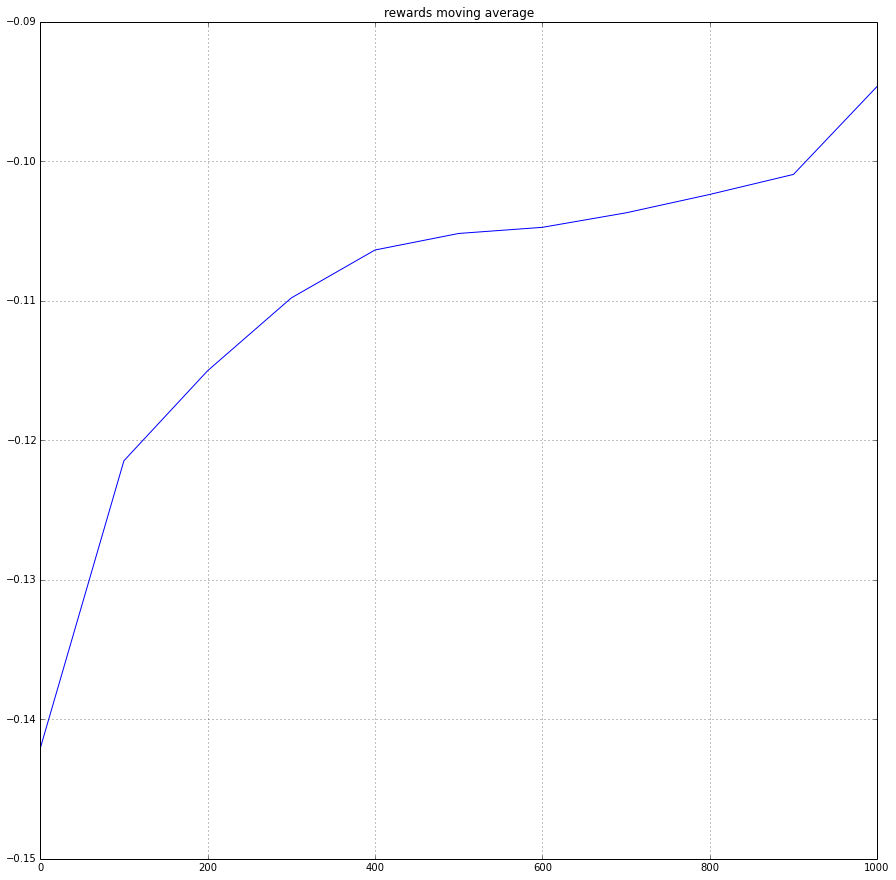

epoch 1100, reward -0.0909532190661, greed 0.282321542501
epoch 1200, reward -0.0872960766379, greed 0.298850864172
epoch 1300, reward -0.0835844994012, greed 0.315111368895
epoch 1400, reward -0.0761709119345, greed 0.331111729145
epoch 1500, reward -0.069650252944, greed 0.346860080957
epoch 1600, reward -0.0618573719877, greed 0.362364262342
epoch 1700, reward -0.0516891572527, greed 0.377631723881
epoch 1800, reward -0.0402997481389, greed 0.39266961813
epoch 1900, reward -0.0261232312694, greed 0.407484710217
epoch 2000, reward -0.0132866741932, greed 0.422083497047


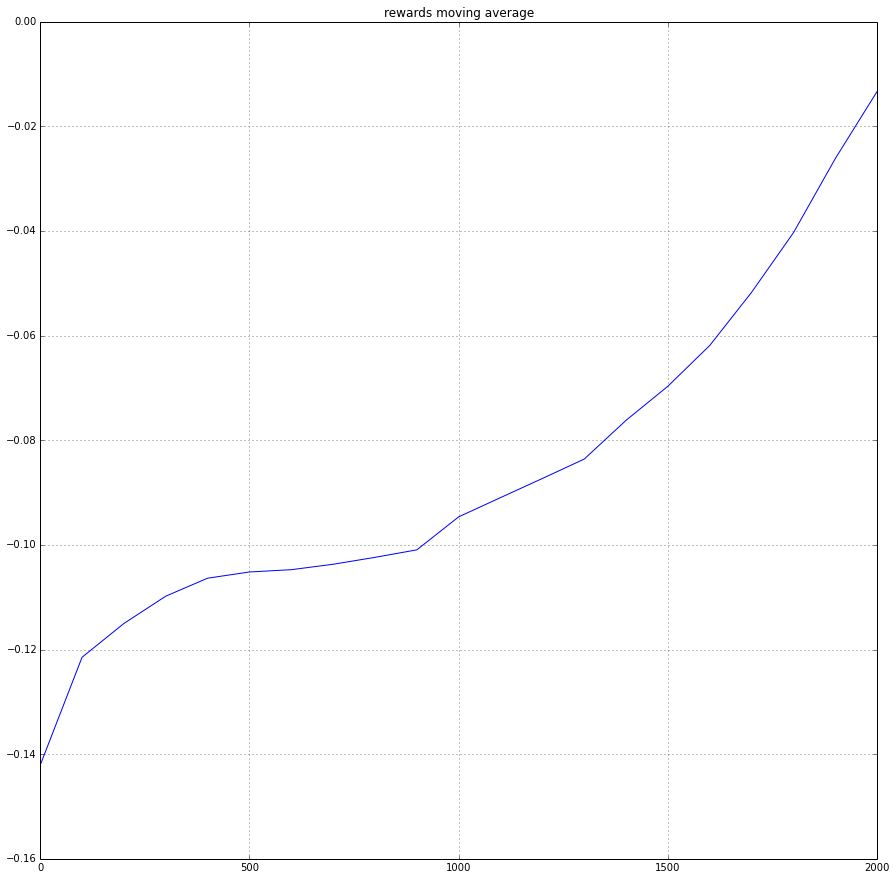

epoch 2100, reward -0.00011072351381, greed 0.43647223711
epoch 2200, reward 0.0167907863268, greed 0.450656861067
epoch 2300, reward 0.0280819036228, greed 0.464643120766
epoch 2400, reward 0.0424873736024, greed 0.478436440229
epoch 2500, reward 0.0534877043085, greed 0.492042094469
epoch 2600, reward 0.0600372843732, greed 0.505465090275
epoch 2700, reward 0.0704347361524, greed 0.518710315228
epoch 2800, reward 0.0796782214601, greed 0.531782388687
epoch 2900, reward 0.0843510259617, greed 0.544685840607
epoch 3000, reward 0.0901491668433, greed 0.557424843311


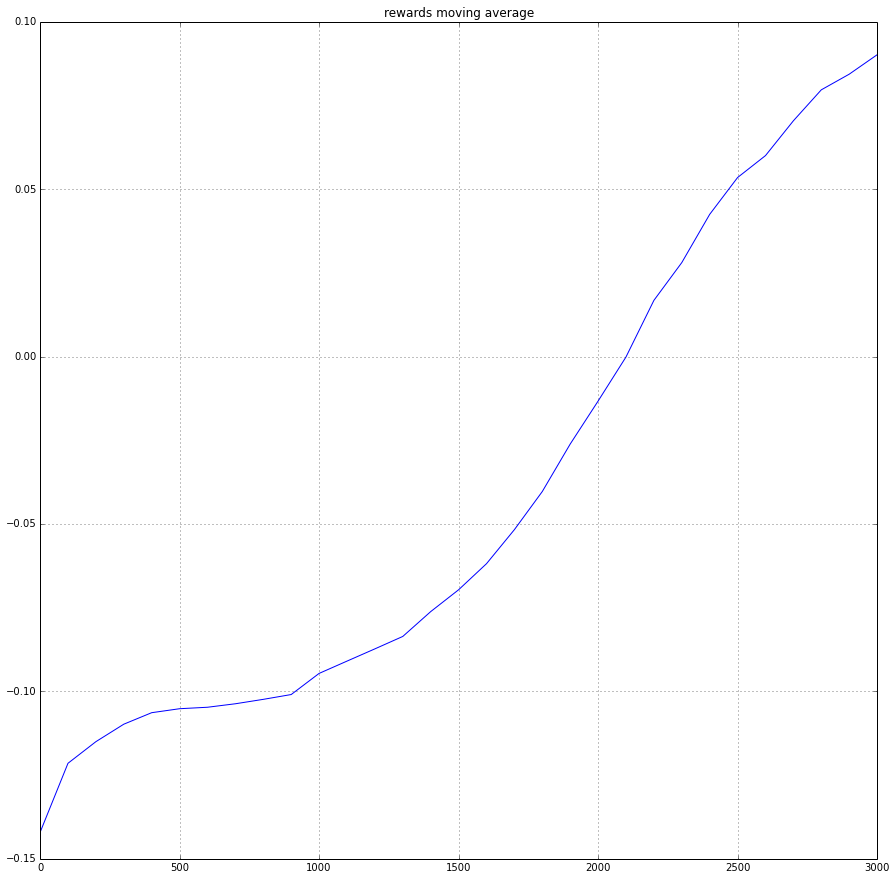

epoch 3100, reward 0.0961873061468, greed 0.570003628731
epoch 3200, reward 0.101295641564, greed 0.582426130772
epoch 3300, reward 0.10900278149, greed 0.594696223736
epoch 3400, reward 0.117004900725, greed 0.606817603111
epoch 3500, reward 0.121248144564, greed 0.618793785572
epoch 3600, reward 0.125481366554, greed 0.630628228188
epoch 3700, reward 0.126553430815, greed 0.642324268818
epoch 3800, reward 0.132973014901, greed 0.653885126114
epoch 3900, reward 0.139269756003, greed 0.665313780308
epoch 4000, reward 0.139274845006, greed 0.676613390446


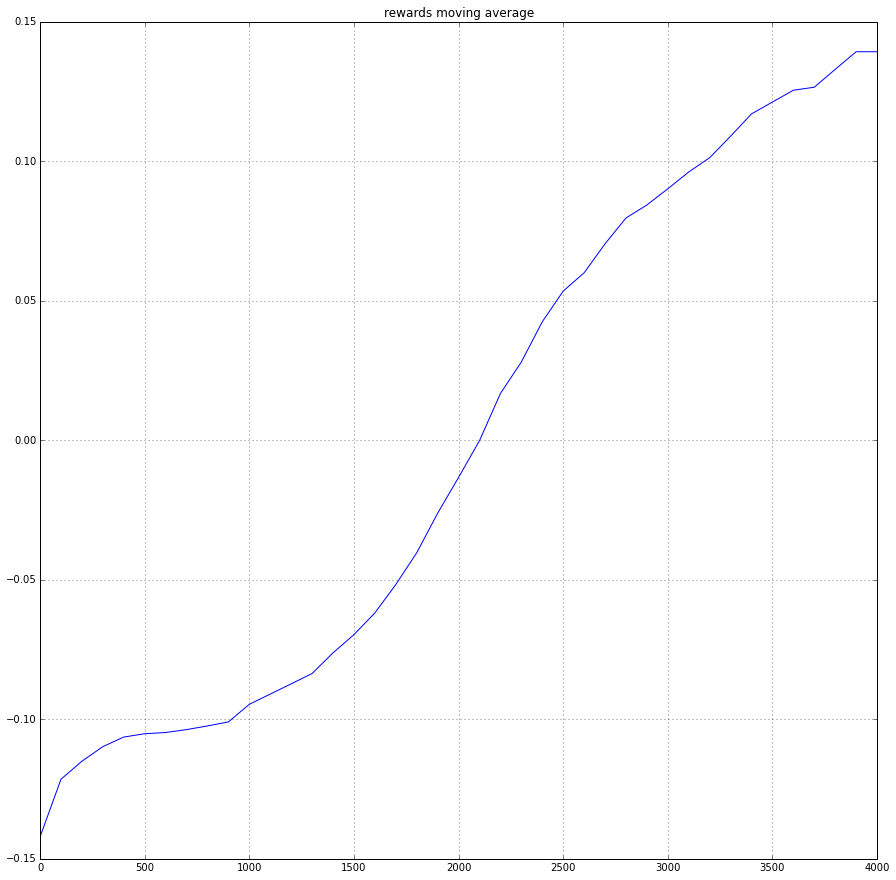

epoch 4100, reward 0.141850609552, greed 0.687786638737
epoch 4200, reward 0.145457923602, greed 0.698836505413
epoch 4300, reward 0.148279366971, greed 0.709765553474
epoch 4400, reward 0.151514136961, greed 0.72057646513
epoch 4500, reward 0.155982981899, greed 0.731271803379
epoch 4600, reward 0.161504053017, greed 0.741853892803
epoch 4700, reward 0.165289506145, greed 0.752325177193
epoch 4800, reward 0.16921683057, greed 0.762687981129
epoch 4900, reward 0.174294477965, greed 0.772944450378
epoch 5000, reward 0.179411523509, greed 0.783096849918


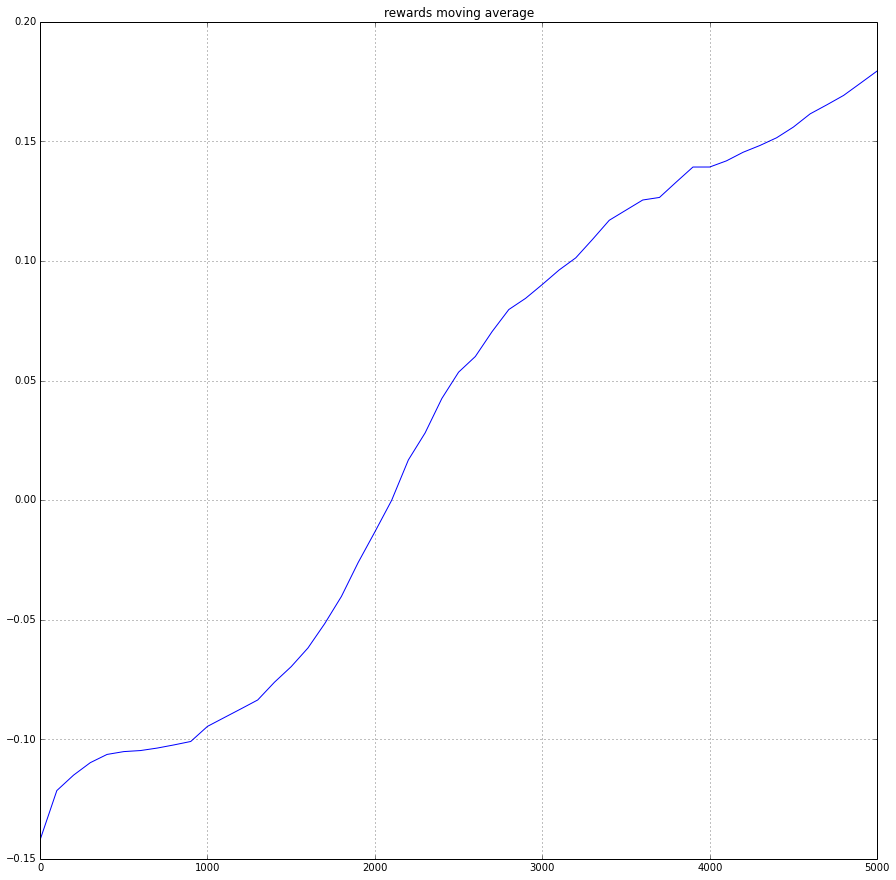

epoch 5100, reward 0.181875558911, greed 0.793147206306
epoch 5200, reward 0.189361682166, greed 0.803097486496
epoch 5300, reward 0.194634392728, greed 0.812949836254
epoch 5400, reward 0.19770814536, greed 0.822705984116
epoch 5500, reward 0.204315471904, greed 0.832367897034
epoch 5600, reward 0.207961268695, greed 0.841937363148
epoch 5700, reward 0.214653397905, greed 0.851416110992
epoch 5800, reward 0.218882991558, greed 0.860805809498
epoch 5900, reward 0.224511094485, greed 0.870108246803
epoch 6000, reward 0.229585550465, greed 0.87932485342


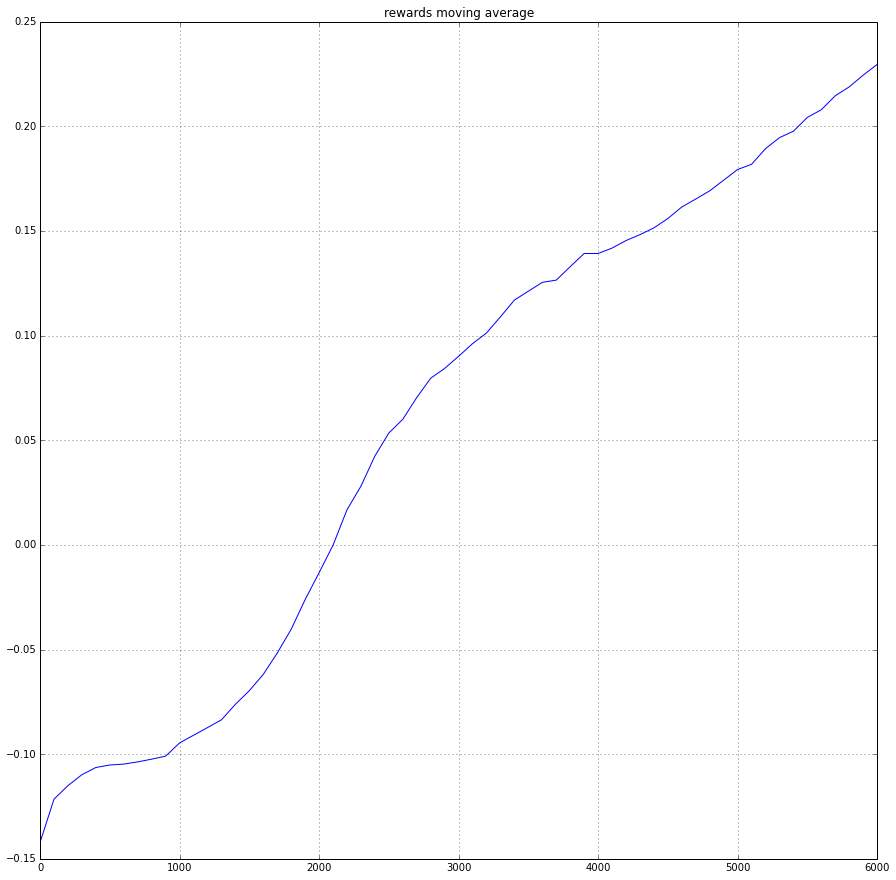

epoch 6100, reward 0.237210988907, greed 0.888457357883
epoch 6200, reward 0.248261114516, greed 0.897507190704
epoch 6300, reward 0.251767251653, greed 0.906475841999
epoch 6400, reward 0.257712816265, greed 0.915364801884
epoch 6500, reward 0.261239593725, greed 0.924175441265
epoch 6600, reward 0.263135685404, greed 0.93290913105
epoch 6700, reward 0.25713050393, greed 0.941567182541
epoch 6800, reward 0.241776283482, greed 0.95015090704
epoch 6900, reward 0.209301480196, greed 0.958661615849
epoch 7000, reward 0.163998735515, greed 0.96710050106


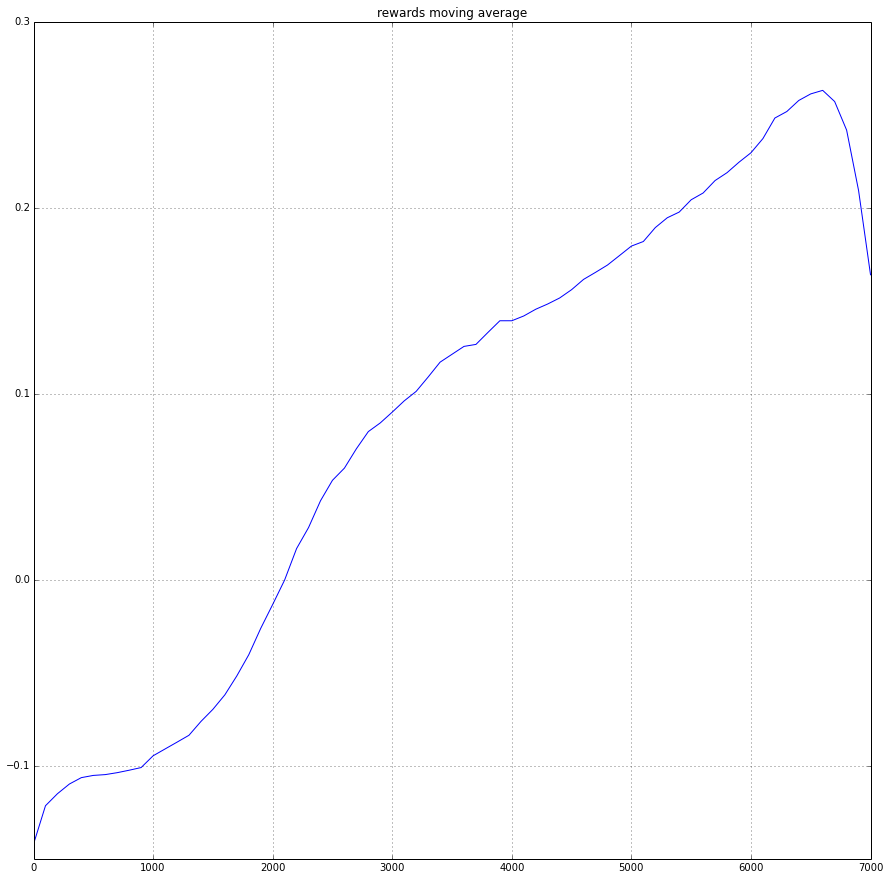

epoch 7100, reward 0.138899103622, greed 0.975468754768
epoch 7200, reward 0.123273426404, greed 0.983767569065
epoch 7300, reward 0.106033726593, greed 0.991998016834
epoch 7400, reward 0.0883722123723, greed 1.00016140938
epoch 7500, reward 0.0852308805401, greed 1.00825858116
epoch 7600, reward 0.0855303214098, greed 1.01629078388
epoch 7700, reward 0.0890194767003, greed 1.02425885201
epoch 7800, reward 0.0903417344388, greed 1.03216409683
epoch 7900, reward 0.0782153087612, greed 1.04000723362
epoch 8000, reward 0.0737039336488, greed 1.04778945446


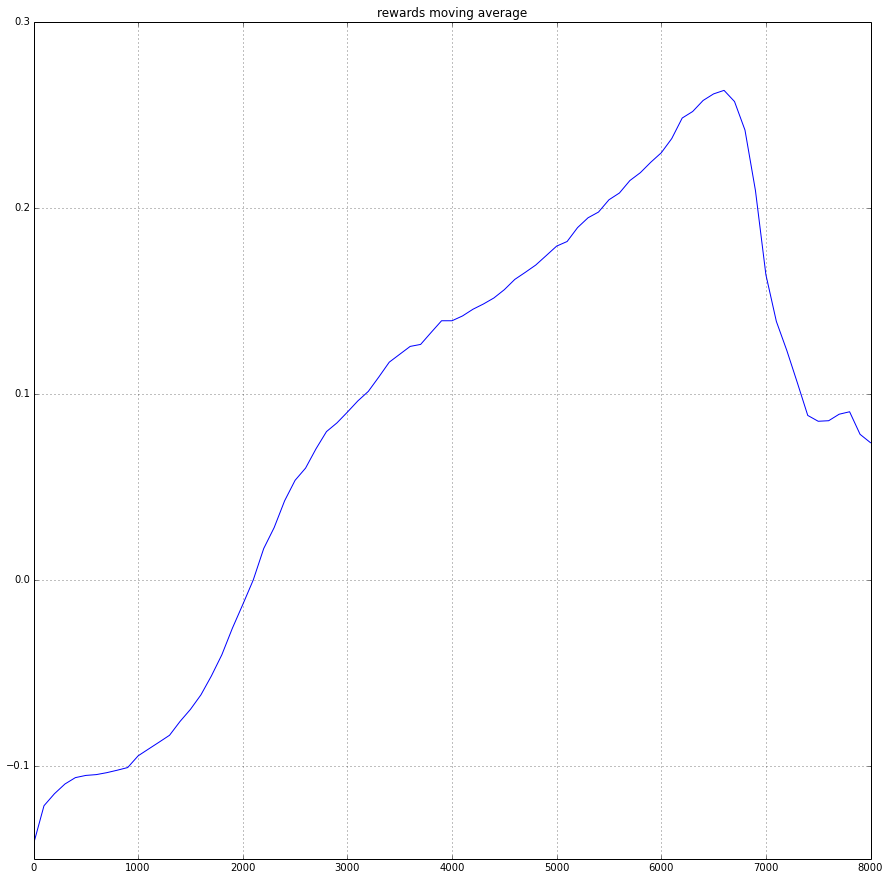

epoch 8100, reward 0.0741912509194, greed 1.05551147461
epoch 8200, reward 0.0737799636951, greed 1.06317436695
epoch 8300, reward 0.0761102364474, greed 1.07077896595
epoch 8400, reward 0.0775785067182, greed 1.07832610607
epoch 8500, reward 0.078995308931, greed 1.08581674099
epoch 8600, reward 0.0818010226635, greed 1.09325182438
epoch 8700, reward 0.0763060929052, greed 1.10063183308
epoch 8800, reward 0.0798983965607, greed 1.10795795918
epoch 8900, reward 0.0788063865711, greed 1.11523067951
epoch 9000, reward 0.0806793261575, greed 1.12245094776


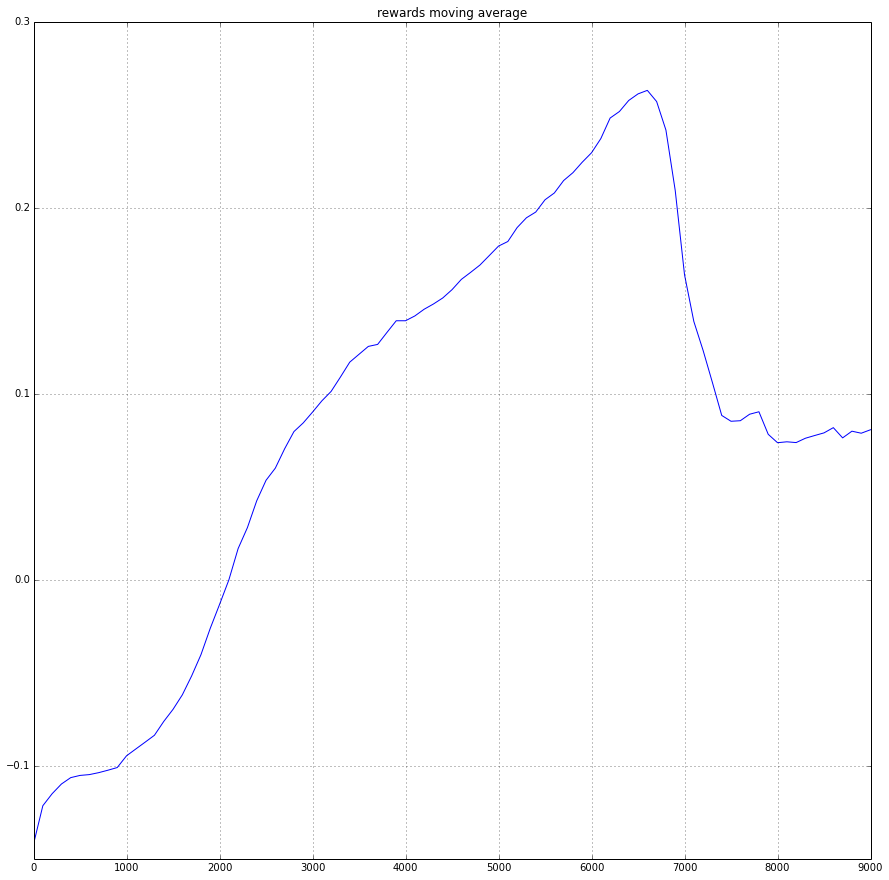

epoch 9100, reward 0.0755785429514, greed 1.12961935997
epoch 9200, reward 0.0672705673618, greed 1.13673686981
epoch 9300, reward 0.0707063971323, greed 1.14380407333
epoch 9400, reward 0.0735586566445, greed 1.15082156658
epoch 9500, reward 0.0728541433545, greed 1.15779030323
epoch 9600, reward 0.0749783669908, greed 1.16471076012
epoch 9700, reward 0.081398718365, greed 1.1715836525
epoch 9800, reward 0.0862815544221, greed 1.17840957642
epoch 9900, reward 0.0859527554382, greed 1.18518924713
epoch 10000, reward 0.0928441905529, greed 1.19192326069


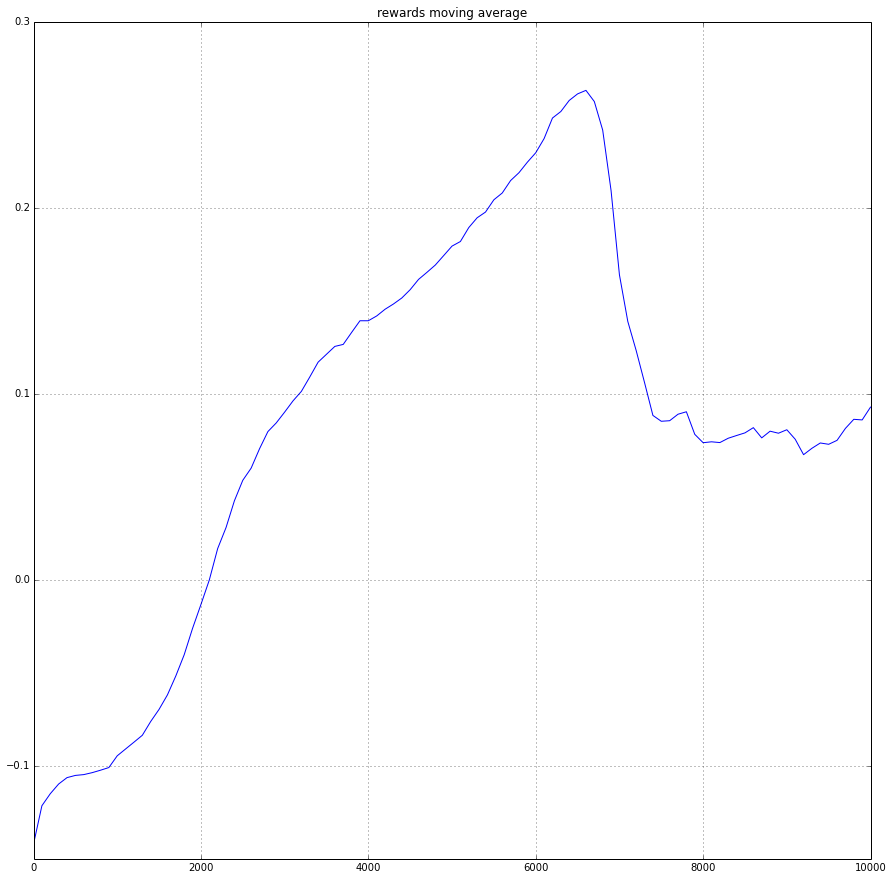

epoch 10100, reward 0.0948363770068, greed 1.19861233234
epoch 10200, reward -0.0618820830919, greed 1.20525681973
epoch 10300, reward -0.192219610849, greed 1.2118575573
epoch 10400, reward -0.170942549514, greed 1.21841490269
epoch 10500, reward -0.17141907073, greed 1.22492957115
epoch 10600, reward -0.183890564196, greed 1.23140215874
epoch 10700, reward -0.192266471649, greed 1.23783302307
epoch 10800, reward -0.195778200748, greed 1.2442227602
epoch 10900, reward -0.197256008673, greed 1.25057208538
epoch 11000, reward -0.196994399006, greed 1.25688123703


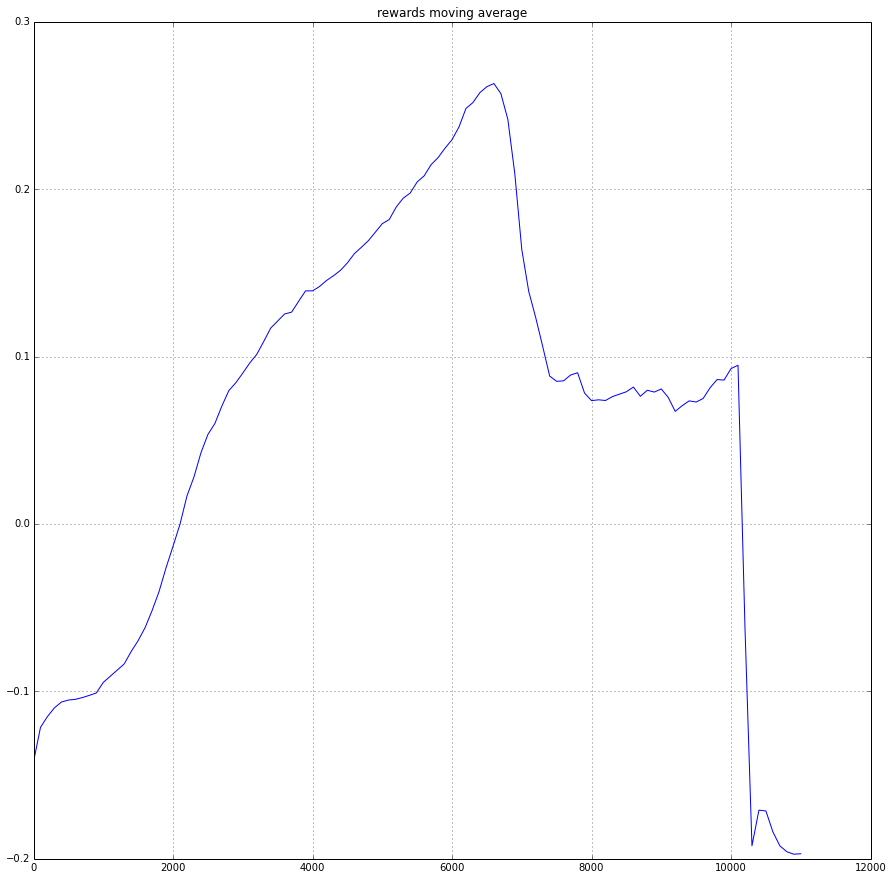

epoch 11100, reward -0.195378254221, greed 1.2631508112


KeyboardInterrupt: 

In [17]:


for i in range(1000000):
    env.prepare_sessions()
    reward = train_fun()
    ma_reward = alpha*reward + (1-alpha)*ma_reward
    
    if epochCounter%100 ==0:
        print "epoch %i, reward %s, greed %s"%(epochCounter, ma_reward,_greediness.get_value())
        rewards[epochCounter] = ma_reward
        _greediness.set_value(np.array(min(0.1+np.log(epochCounter/5000.+1),1.5),dtype=floatX))
    if epochCounter%1000 ==0:
        plt.figure(figsize=[15,15])
        plt.plot(*zip(*sorted(rewards.items())))
        plt.title('rewards moving average')
        plt.grid()
        plt.show()
    epochCounter  +=1


In [238]:
theano.printing.pydotprint(_prediction,'graph_prediction.png')

The output file is available at graph_prediction.png


In [148]:
theano.printing.pydotprint(_loss,'graph_loss.png')

TypeError: must be string or buffer, not list

In [124]:
_nn_params = lasagne.layers.get_all_params(_rnn)
_nn_params

[mdp_gru.W_in_to_updategate,
 mdp_gru.W_hid_to_updategate,
 mdp_gru.b_updategate,
 mdp_gru.W_in_to_resetgate,
 mdp_gru.W_hid_to_resetgate,
 mdp_gru.b_resetgate,
 mdp_gru.W_in_to_hidden_update,
 mdp_gru.W_hid_to_hidden_update,
 mdp_gru.b_hidden_update]